In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 7
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 1e-24
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 300
vmax = 1380
vmin = 1215
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.55, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

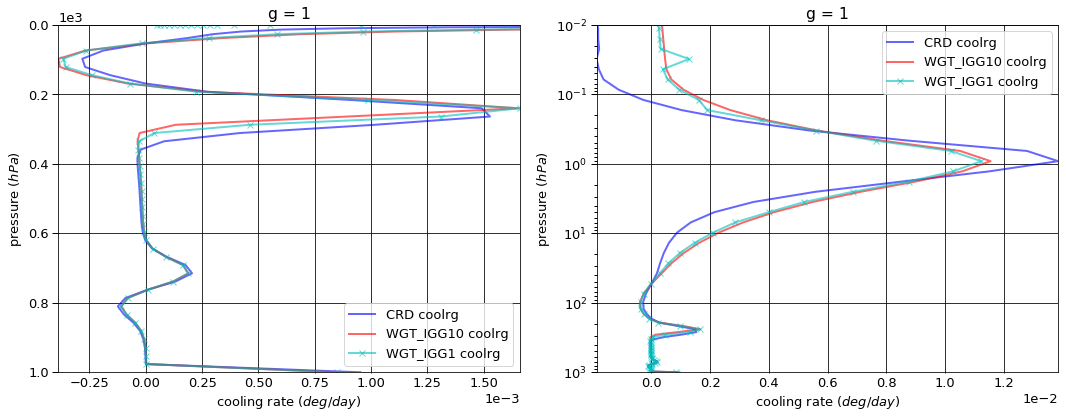

# Figure: cooling rate g-group 2

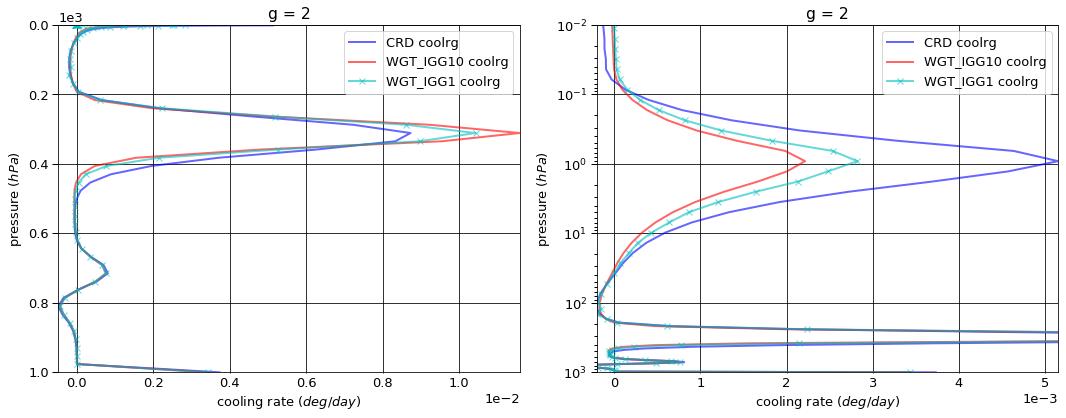

# Figure: cooling rate g-group 3

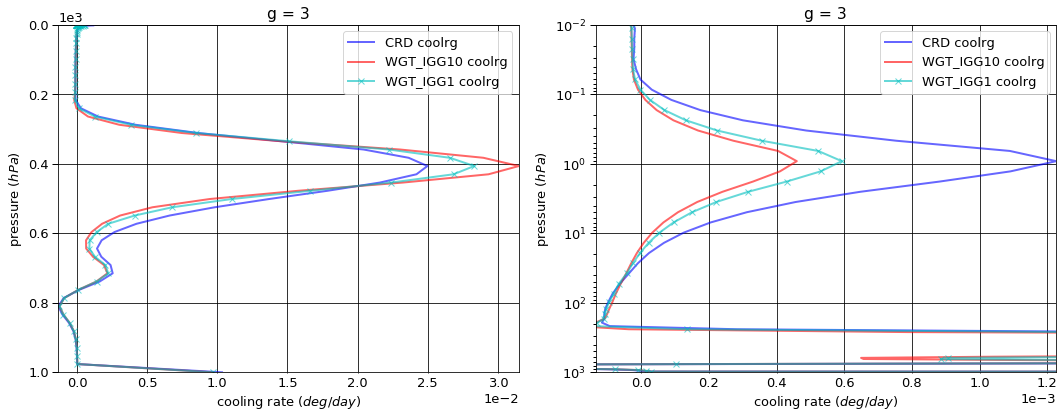

# Figure: cooling rate g-group 4

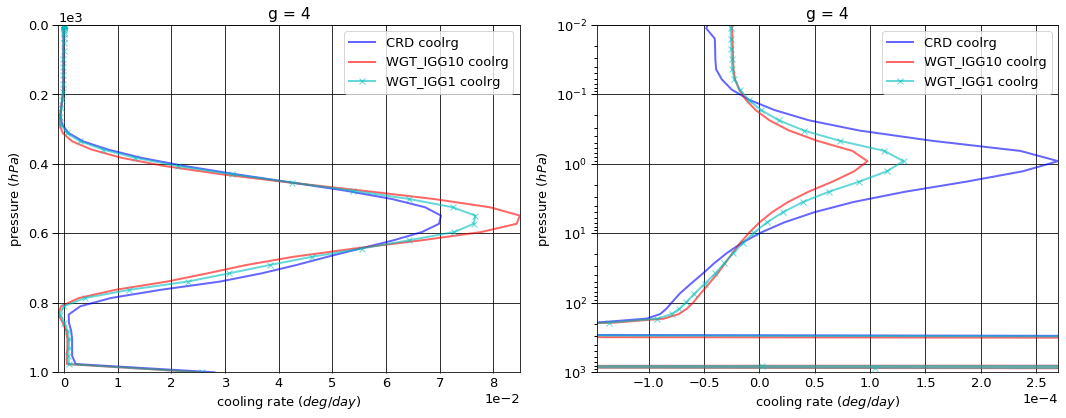

# Figure: cooling rate g-group 5

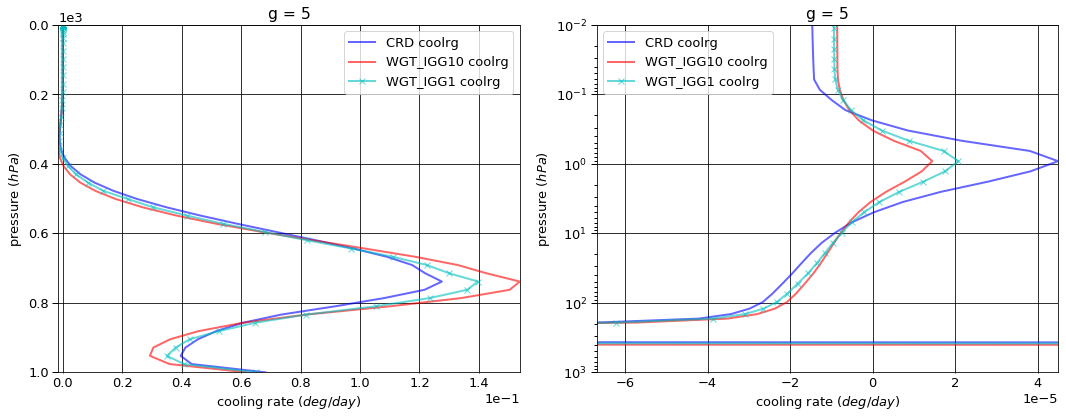

# Figure: cooling rate g-group 6

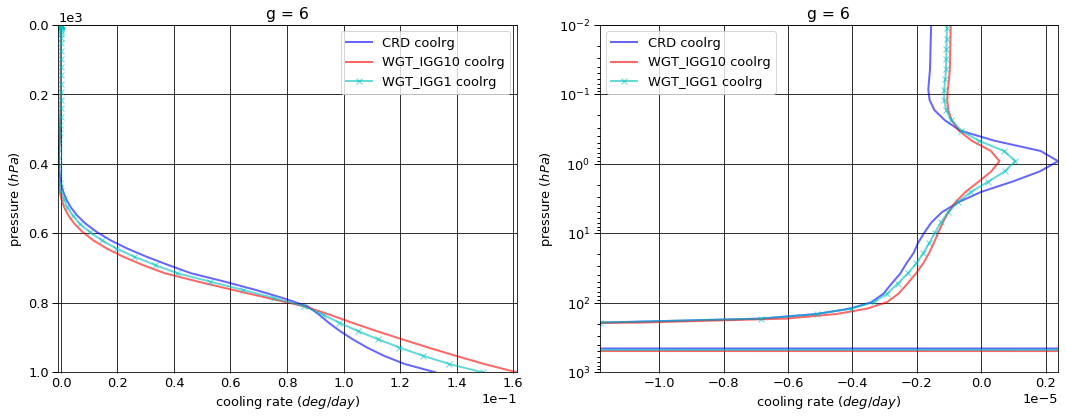

# Figure: cooling rate g-group 7

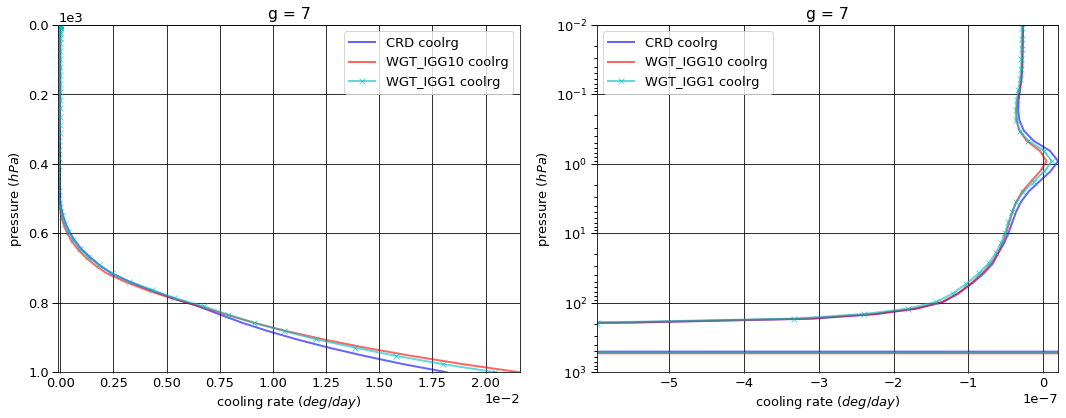

# Figure: cooling rate g-group total

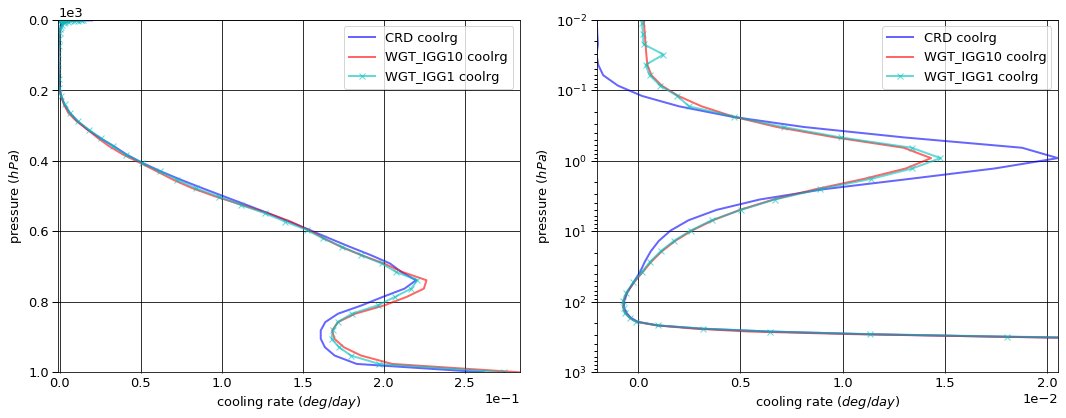

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024556  0.000000 -0.024556
  1013.0   76    -0.199577  0.196871 -0.002707
2 0.0      1     -0.150331  0.000000 -0.150331
  1013.0   76    -0.792032  0.781429 -0.010603
3 0.0      1     -0.637875  0.000000 -0.637875
  1013.0   76    -2.209403  2.180052 -0.029351
4 0.0      1     -2.484515  0.000000 -2.484515
  1013.0   76    -5.701357  5.618817 -0.082540
5 0.0      1     -5.096692  0.000000 -5.096692
  1013.0   76    -8.161593  7.778532 -0.383061
6 0.0      1     -6.672296  0.000000 -6.672296
  1013.0   76    -7.897348  5.005659 -2.891689
7 0.0      1     -1.918676  0.000000 -1.918676
  1013.0   76    -2.001435  0.435129 -1.566306


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.021503  0.000000 -0.021503
  1013.0   76    -0.186891  0.184481 -0.002410
2 0.0      1     -0.146770  0.000000 -0.146770
  1013.0   76    -0.754619  0.744887 -0.009731
3 0.0      1     -0.622787  0.000000 -0.622787
  1013.0   76    -2.126953  2.099525 -0.027429
4 0.0      1     -2.432907  0.000000 -2.432907
  1013.0   76    -5.520190  5.448253 -0.071937
5 0.0      1     -5.119189  0.000000 -5.119189
  1013.0   76    -8.124837  7.862045 -0.262792
6 0.0      1     -6.967377  0.000000 -6.967377
  1013.0   76    -8.134660  5.126955 -3.007705
7 0.0      1     -2.024791  0.000000 -2.024791
  1013.0   76    -2.114595  0.473320 -1.641275


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.022856  0.000000 -0.022856
  1013.0   76    -0.186891  0.184481 -0.002410
2 0.0      1     -0.146399  0.000000 -0.146399
  1013.0   76    -0.754619  0.744887 -0.009731
3 0.0      1     -0.622473  0.000000 -0.622473
  1013.0   76    -2.126953  2.099525 -0.027429
4 0.0      1     -2.430372  0.000000 -2.430372
  1013.0   76    -5.520190  5.447184 -0.073006
5 0.0      1     -5.102016  0.000000 -5.102016
  1013.0   76    -8.124837  7.831035 -0.293802
6 0.0      1     -6.913626  0.000000 -6.913626
  1013.0   76    -8.134660  5.096784 -3.037876
7 0.0      1     -2.022473  0.000000 -2.022473
  1013.0   76    -2.114595  0.470772 -1.643824


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.003053  0.000000  0.003053
  1013.0   76     0.012686 -0.012389  0.000296
2 0.0      1      0.003561  0.000000  0.003561
  1013.0   76     0.037414 -0.036542  0.000872
3 0.0      1      0.015088  0.000000  0.015088
  1013.0   76     0.082449 -0.080527  0.001922
4 0.0      1      0.051608  0.000000  0.051608
  1013.0   76     0.181167 -0.170563  0.010604
5 0.0      1     -0.022497  0.000000 -0.022497
  1013.0   76     0.036756  0.083513  0.120269
6 0.0      1     -0.295081  0.000000 -0.295081
  1013.0   76    -0.237312  0.121296 -0.116016
7 0.0      1     -0.106115  0.000000 -0.106115
  1013.0   76    -0.113160  0.038191 -0.074969


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001700  0.000000  0.001700
  1013.0   76     0.012686 -0.012389  0.000296
2 0.0      1      0.003932  0.000000  0.003932
  1013.0   76     0.037414 -0.036542  0.000872
3 0.0      1      0.015403  0.000000  0.015403
  1013.0   76     0.082449 -0.080527  0.001922
4 0.0      1      0.054143  0.000000  0.054143
  1013.0   76     0.181167 -0.171632  0.009535
5 0.0      1     -0.005324  0.000000 -0.005324
  1013.0   76     0.036756  0.052503  0.089259
6 0.0      1     -0.241329  0.000000 -0.241329
  1013.0   76    -0.237312  0.091125 -0.146187
7 0.0      1     -0.103797  0.000000 -0.103797
  1013.0   76    -0.113160  0.035643 -0.077517

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.002683e-03
  1001.112500 75     9.524886e-04
2 0.000312    1     -1.996637e-04
  1001.112500 75     3.733272e-03
3 0.000312    1     -5.128475e-05
  1001.112500 75     1.033748e-02
4 0.000312    1     -4.615147e-05
  1001.112500 75     2.807245e-02
5 0.000312    1     -1.494687e-05
  1001.112500 75     6.818404e-02
6 0.000312    1     -1.479657e-06
  1001.112500 75     1.325374e-01
7 0.000312    1     -2.524414e-08
  1001.112500 75     1.817268e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.568957e-04
  1001.112500 75     8.498370e-04
2 0.000312    1     -5.493463e-05
  1001.112500 75     3.431423e-03
3 0.000312    1     -3.371066e-05
  1001.112500 75     9.671743e-03
4 0.000312    1     -2.645463e-05
  1001.112500 75     2.538712e-02
5 0.000312    1     -8.601331e-06
  1001.112500 75     6.179634e-02
6 0.000312    1     -8.908608e-07
  1001.112500 75     1.612947e-01
7 0.000312    1     -2.487489e-08
  1001.112500 75     2.160636e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      5.183066e-05
  1001.112500 75     8.498370e-04
2 0.000312    1     -4.278734e-05
  1001.112500 75     3.431423e-03
3 0.000312    1     -3.491023e-05
  1001.112500 75     9.671743e-03
4 0.000312    1     -2.855265e-05
  1001.112500 75     2.567374e-02
5 0.000312    1     -9.486944e-06
  1001.112500 75     6.511514e-02
6 0.000312    1     -1.008132e-06
  1001.112500 75     1.492451e-01
7 0.000312    1     -2.629185e-08
  1001.112500 75     2.045822e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.159579e-03
  1001.112500 75    -1.026515e-04
2 0.000312    1      1.447291e-04
  1001.112500 75    -3.018500e-04
3 0.000312    1      1.757409e-05
  1001.112500 75    -6.657383e-04
4 0.000312    1      1.969684e-05
  1001.112500 75    -2.685321e-03
5 0.000312    1      6.345540e-06
  1001.112500 75    -6.387694e-03
6 0.000312    1      5.887957e-07
  1001.112500 75     2.875731e-02
7 0.000312    1      3.692510e-10
  1001.112500 75     3.433675e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.054514e-03
  1001.112500 75    -1.026515e-04
2 0.000312    1      1.568764e-04
  1001.112500 75    -3.018500e-04
3 0.000312    1      1.637452e-05
  1001.112500 75    -6.657383e-04
4 0.000312    1      1.759882e-05
  1001.112500 75    -2.398703e-03
5 0.000312    1      5.459927e-06
  1001.112500 75    -3.068894e-03
6 0.000312    1      4.715241e-07
  1001.112500 75     1.670768e-02
7 0.000312    1     -1.047711e-09
  1001.112500 75     2.285537e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.984941,0.000000,-16.984941
1013.0,76,-26.962746,21.996489,-4.966257



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.335324,0.000000,-17.335324
1013.0,76,-26.962746,21.939467,-5.023279



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.260214,0.000000,-17.260214
1013.0,76,-26.962746,21.874668,-5.088078



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.503828e-01,0.000000,-0.350383
1013.0,76,-1.700000e-07,-0.057022,-0.057022



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.752730e-01,0.000000,-0.275273
1013.0,76,-1.700000e-07,-0.121821,-0.121821


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.002316
1001.112500,75,0.261990



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000032
1001.112500,75,0.284038



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000065
1001.112500,75,0.274445



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002349
1001.112500,75,0.022048



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002251
1001.112500,75,0.012455


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008727,0.006931
2,0.033164,0.027987
3,0.090315,0.078885
4,0.229558,0.204734
5,0.305091,0.301336
6,0.269358,0.301700
7,0.063788,0.078427


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.634434e-20
2,2.348017e-21
3,3.373146e-22
4,4.845840e-23
5,6.961502e-24
6,1.000085e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.634434e-20,NaN,0.008727,0.006931,0.008727,0.006931,600.0
2,2.348017e-21,0.143659,0.033164,0.027987,0.041891,0.034919,600.0
3,3.373146e-22,0.143659,0.090315,0.078885,0.132206,0.113804,600.0
4,4.845840e-23,0.143659,0.229558,0.204734,0.361764,0.318538,600.0
5,6.961502e-24,0.143659,0.305091,0.301336,0.666855,0.619873,600.0
6,1.000085e-24,0.143659,0.269358,0.301700,0.936212,0.921573,600.0
7,1.858499e-25,0.185834,0.063788,0.078427,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
